In [4]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import math
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Compose, Normalize
from torch.utils.data import DataLoader
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import StepLR
import torch.distributions as distributions
from tqdm import tqdm
from copy import deepcopy

In [14]:
class RectifiedFlow:
  def euler(self,x_t,v,dt):
    x_t=x_t+v*dt
    return x_t
  def create_flow(self,x_1,t):
    x_0=torch.randn_like(x_1)
    t=t.unsqueeze(1)
    x_t=t*x_1+(1-t)*x_0
    return x_t,x_0
  def mse_loss(self,x_1,x_0,v):
    loss=F.mse_loss(x_1-x_0,v)
    return loss

In [15]:
class TimeEmbedding(nn.Module):
  def __init__(self,embed_dim,scale=30):
    super().__init__()
    d=embed_dim//2
    w=torch.randn(d)*scale
    self.register_buffer('W',w,persistent=True)
  def forward(self,t):
    x_proj=t[:,None]*self.W[None,:]*2*math.pi
    return torch.cat([torch.sin(x_proj),torch.cos(x_proj)],dim=-1)

In [16]:
class ScalarNet(nn.Module):
    def __init__(self, t_dim=128, hidden_dim=512):  # Larger hidden dimension
        super().__init__()

        # Enhanced time embedding
        self.time_mlp = nn.Sequential(
            TimeEmbedding(embed_dim=t_dim, scale=30),
            nn.Linear(t_dim, t_dim),
            nn.SiLU(),
            nn.Dropout(0.1),  # Add dropout for regularization
            nn.Linear(t_dim, t_dim),
            nn.SiLU(),
            nn.Linear(t_dim, t_dim)
        )

        # Deeper network with skip connections
        self.input_layer = nn.Linear(2 + t_dim, hidden_dim)

        # Residual blocks
        self.blocks = nn.ModuleList([
            self._make_block(hidden_dim) for _ in range(6)  # More layers
        ])

        self.output_layer = nn.Linear(hidden_dim, 2)

        # Better initialization
        self._initialize_weights()

    def _make_block(self, dim):
        return nn.Sequential(
            nn.Linear(dim, dim),
            nn.GroupNorm(1, dim),
            nn.SiLU(),
            nn.Dropout(0.1),
            nn.Linear(dim, dim),
            nn.GroupNorm(1, dim),
        )

    def _initialize_weights(self):
        # Initialize output layer to small values
        nn.init.zeros_(self.output_layer.weight)
        nn.init.zeros_(self.output_layer.bias)

        # Initialize other layers with proper scaling
        for m in self.modules():
            if isinstance(m, nn.Linear) and m != self.output_layer:
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x, t):
        t_emb = self.time_mlp(t)
        h = torch.cat([x, t_emb], dim=1)

        h = F.silu(self.input_layer(h))

        # Apply residual blocks
        for block in self.blocks:
            residual = h
            h = block(h) + residual  # Skip connection
            h = F.silu(h)

        return self.output_layer(h)

#Training

In [17]:
class EMA(nn.Module):
    def __init__(self, model, decay=0.9999, device=None):
        super(EMA, self).__init__()
        # make a copy of the model for accumulating moving average of weights
        self.module = deepcopy(model)
        self.module.eval()
        self.decay = decay
        self.device = device  # perform EMA on different device from model if set
        if self.device is not None:
            self.module.to(device=self.device)

    def _update(self, model, update_fn):
        with torch.no_grad():
            for ema_v, model_v in zip(self.module.state_dict().values(),
                                      model.state_dict().values()):
                if self.device is not None:
                    model_v = model_v.to(device=self.device)
                ema_v.copy_(update_fn(ema_v, model_v))

    def update(self, model):
        self._update(
            model,
            update_fn=lambda e, m: self.decay * e + (1.0 - self.decay) * m
        )

    def set(self, model):
        self._update(
            model,
            update_fn=lambda e, m: m
        )

In [20]:
# Improved training configuration
epochs= 100  # More epochs
batch_size= 128  # Larger batch size for more stable gradients
lr= 5e-4  # Slightly higher learning rate initially
weight_decay= 1e-4  # Less regularization
ema_decay= 0.9999
grad_clip= 1.0
lr_schedule= True
step_size= 40  # Reduce LR later
gamma= 0.5 # More gradual LR reduction
lr_adjust_epoch= 25 # 学习率调整的epoch，降为原有的10%
batch_print_interval= 100 # 打印间隔，以batch为单位
device= 'cuda' # cuda、cpu、mps(only macbook)
checkpoint_save_interval= 10 # 模型保存间隔，以epoch为单位

In [21]:
nu=2
N=100000
batch_size=64
# Create the Dataset
mean_coor=torch.tensor([[-10,0],[10,0]],device=device)
mask=torch.bernoulli(torch.full((N,),0.01,device=device)).long()
mus=mean_coor[mask]
sigmas=torch.randn(N,2,device=device)
data=mus+sigmas


dataset=torch.utils.data.TensorDataset(data.cpu())
loader=DataLoader(dataset,batch_size,shuffle=True)
model=ScalarNet(128,256)
model.to(device)
optimiser=AdamW(model.parameters(),lr=1e-4,weight_decay=0.1)
scheduler=StepLR(optimiser,step_size=lr_adjust_epoch,gamma=0.1)
ema = EMA(model, decay=0.999, device=device)
rf=RectifiedFlow()
for epoch in range(epochs):
  pbar=tqdm(loader,desc=f'Epoch {epoch}')
  for (data,) in pbar:
    x_1=data
    t=torch.rand(x_1.size(0))
    x_t,x_0=rf.create_flow(x_1,t)
    x_t = x_t.to(device)
    x_0 = x_0.to(device)
    x_1 = x_1.to(device)
    t = t.to(device)
    optimiser.zero_grad()
    v_pred=model(x_t,t)
    loss=rf.mse_loss(x_1,x_0,v_pred)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimiser.step()
    ema.update(model)
  if epoch % 5 == 0:
        torch.save({
            'model_state_dict': model.state_dict(),
            'ema_state_dict': ema.state_dict(),
            'optimizer_state_dict': optimiser.state_dict(),
            'epoch': epoch,
            'loss': loss
        }, f"scalar_ckpt_{epoch}.pth")

Epoch 99: 100%|██████████| 1563/1563 [00:33<00:00, 46.86it/s]


# Sampling and Evaluation

Now let's generate new samples from the trained model and compare them with the real t-distribution.

In [22]:
def sample_from_model(model, rf, num_samples=2000, num_steps=50, device='cuda'):
    """
    Generate samples from the trained rectified flow model
    """
    model.eval()
    with torch.no_grad():
        # Start from random noise
        x_t = torch.randn(num_samples, 2).to(device)

        # Integration step size
        dt = 1.0 / num_steps

        # Euler integration from t=0 to t=1
        for step in range(num_steps):
            t = torch.full((num_samples,), step * dt).to(device)

            # Get velocity prediction
            v_pred = model(x_t, t)

            # Euler step: x_{t+dt} = x_t + v_pred * dt
            x_t = rf.euler(x_t, v_pred, dt)

    return x_t.cpu().numpy()

# Use EMA model for sampling (better quality)
sampling_model = ema.module
sampling_model.eval()

# Generate samples using EMA model
print("Generating samples from trained EMA model...")
generated_samples = sample_from_model(sampling_model, rf, num_samples=10000, num_steps=50, device=device)

print(f"Generated {len(generated_samples)} samples")
print(f"Sample statistics:")
print(f"  Mean: {generated_samples.mean():.4f}")
print(f"  Std: {generated_samples.std():.4f}")
print(f"  Min: {generated_samples.min():.4f}")
print(f"  Max: {generated_samples.max():.4f}")

Generating samples from trained EMA model...
Generated 10000 samples
Sample statistics:
  Mean: -4.9599
  Std: 5.1468
  Min: -13.9389
  Max: 13.8679


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


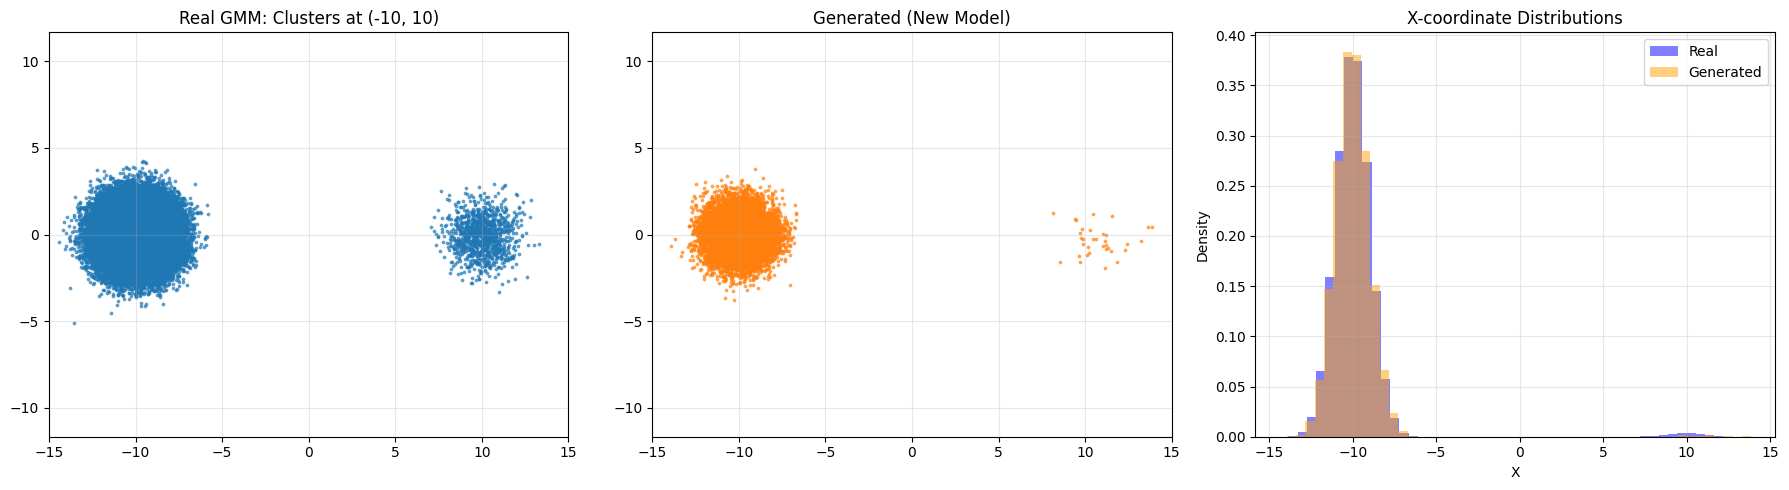


=== DETAILED ANALYSIS (NEW MODEL) ===
Real data statistics:
  Mean: [-9.7911615e+00 -1.4585786e-03]
  Std: [2.261069  1.0000654]

Generated samples statistics:
  Mean: [-9.93933     0.01946764]
  Std: [1.5665942 0.9678169]


In [26]:
import matplotlib.pyplot as plt
import numpy as np
# Generate true t-distribution samples for comparison
mean_coor=torch.tensor([[-10,0],[10,0]],device=device)
mask=torch.bernoulli(torch.full((N,),0.01,device=device)).long()
mus=mean_coor[mask]
sigmas=torch.randn(N,2,device=device)
data=mus+sigmas
real_samples_new = data.cpu().numpy()

# Plot comparison
plt.figure(figsize=(18, 5))

# Subplot 1: Real GMM (new dataset)
plt.subplot(1, 3, 1)
plt.scatter(real_samples_new[:, 0], real_samples_new[:, 1], s=3, alpha=0.6, color='C0')
plt.title("Real GMM: Clusters at (-10, 10)")
plt.axis('equal')
plt.xlim(-15, 15)
plt.ylim(-5, 5)
plt.grid(True, alpha=0.3)

# Subplot 2: Generated samples (new model)
plt.subplot(1, 3, 2)
plt.scatter(generated_samples[:, 0], generated_samples[:, 1], s=3, alpha=0.6, color='C1')
plt.title("Generated (New Model)")
plt.axis('equal')
plt.xlim(-15, 15)
plt.ylim(-5, 5)
plt.grid(True, alpha=0.3)

# Subplot 3: Histogram comparison
plt.subplot(1, 3, 3)
plt.hist(real_samples_new[:, 0], bins=50, alpha=0.5, color='blue', label='Real', density=True)
plt.hist(generated_samples[:, 0], bins=50, alpha=0.5, color='orange', label='Generated', density=True)
plt.title("X-coordinate Distributions")
plt.xlabel('X')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print detailed statistics
print("\n=== DETAILED ANALYSIS (NEW MODEL) ===")
print(f"Real data statistics:")
print(f"  Mean: {np.mean(real_samples_new[:], axis=0)}")
print(f"  Std: {np.std(real_samples_new[:], axis=0)}")

print(f"\nGenerated samples statistics:")
print(f"  Mean: {np.mean(generated_samples, axis=0)}")
print(f"  Std: {np.std(generated_samples, axis=0)}")


